In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

In [2]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

In [3]:
class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

In [81]:
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh
import networkx as nx

def load_cora_data():
    data = citegrh.load_cora()
    features = torch.FloatTensor(data.features)
    labels = torch.LongTensor(data.labels)
    mask = torch.BoolTensor(data.train_mask)
    g = data.graph
    # add self loop
    g.remove_edges_from(nx.selfloop_edges(g))
    g = DGLGraph(g)
    g.add_edges(g.nodes(), g.nodes())
    return g, features, labels, mask

In [88]:
import time
import numpy as np

g, features, labels, mask = load_cora_data()

# create the model, 2 heads, each head has hidden size 8
net = GAT(g,
          in_dim=features.size()[1],
          hidden_dim=8,
          out_dim=7,
          num_heads=2)

# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# main loop
dur = []
for epoch in range(30):
    if epoch >= 3:
        t0 = time.time()

    logits = net(features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[mask], labels[mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
        epoch, loss.item(), np.mean(dur)))

/home/herokuma/miniconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/herokuma/miniconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Loss 1.9461 | Time(s) nan
Epoch 00001 | Loss 1.9454 | Time(s) nan
Epoch 00002 | Loss 1.9446 | Time(s) nan
Epoch 00003 | Loss 1.9439 | Time(s) 0.1834
Epoch 00004 | Loss 1.9431 | Time(s) 0.1839
Epoch 00005 | Loss 1.9423 | Time(s) 0.1813
Epoch 00006 | Loss 1.9416 | Time(s) 0.1805
Epoch 00007 | Loss 1.9408 | Time(s) 0.1801
Epoch 00008 | Loss 1.9400 | Time(s) 0.1798
Epoch 00009 | Loss 1.9392 | Time(s) 0.1802
Epoch 00010 | Loss 1.9383 | Time(s) 0.1803
Epoch 00011 | Loss 1.9375 | Time(s) 0.1823
Epoch 00012 | Loss 1.9367 | Time(s) 0.1835
Epoch 00013 | Loss 1.9358 | Time(s) 0.1840
Epoch 00014 | Loss 1.9349 | Time(s) 0.1850
Epoch 00015 | Loss 1.9340 | Time(s) 0.1857
Epoch 00016 | Loss 1.9331 | Time(s) 0.1860
Epoch 00017 | Loss 1.9322 | Time(s) 0.1861
Epoch 00018 | Loss 1.9312 | Time(s) 0.1864
Epoch 00019 | Loss 1.9303 | Time(s) 0.1866
Epoch 00020 | Loss 1.9293 | Time(s) 0.1862
Epoch 00021 | Loss 1.9283 | Time(s) 0.1865
Epoch 00022 | Loss 1.9273 | Time(s) 0.1862
Epoch 00023 | Loss 1

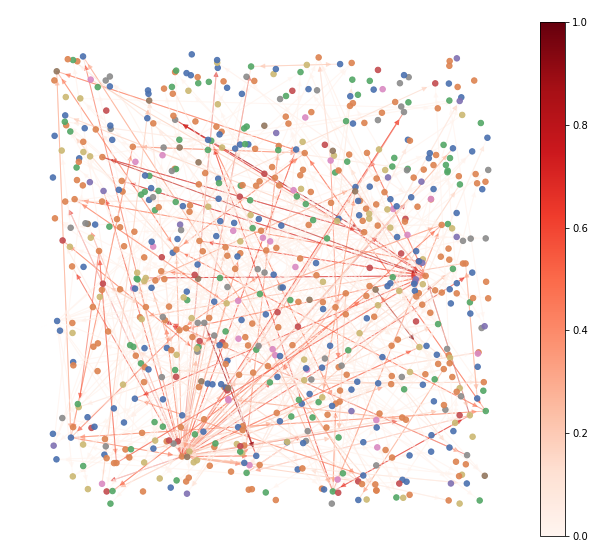

In [436]:
import random
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import math

def plot(g, attention, ax, nodes_to_plot=None, nodes_labels=None,
         edges_to_plot=None, nodes_pos=None, nodes_colors=None,
         edge_colormap=plt.cm.Reds):

    if nodes_to_plot is None:
        nodes_to_plot = sorted(g.nodes())
    if edges_to_plot is None:
        assert isinstance(g, nx.DiGraph), 'Expected g to be an networkx.DiGraph' \
                                          'object, got {}.'.format(type(g))
        edges_to_plot = sorted(g.edges())
#     print(g.edges)
        
    nx.draw_networkx_edges(g, nodes_pos, edgelist=edges_to_plot,
                           edge_color=attention, edge_cmap=edge_colormap,
                           width=1, alpha=0.5, ax=ax, edge_vmin=0,
                           edge_vmax=1)

    if nodes_colors is None:
        nodes_colors = sns.color_palette("deep", max(nodes_labels) + 1)

    nx.draw_networkx_nodes(g, nodes_pos, nodelist=nodes_to_plot, ax=ax, node_size=30,
                           node_color=[nodes_colors[nodes_labels[v - 1]] for v in nodes_to_plot],
                           with_labels=False, alpha=0.9)
    
l = random.sample(range(len(g.nodes())), 700)

sub = g.subgraph(l)
sub.copy_from_parent()

dg = sub.to_networkx().to_directed()
# grEd=dg.edges()
# print(len(grEd))
attention = sub.edata['e'].detach().numpy()
_max = max(attention)
_min = min(attention)
norm = [(float(i)-_min)/(_max-_min) for i in attention]
for i in range(len(norm)):
    norm[i] = norm[i][0]
    
node_val = []
t = np.argsort(sub.ndata['_ID'])
for i in t:
    node_val.append(math.floor(sum(sub.ndata['z'][i])*100))

fig, ax = plt.subplots(figsize=(10, 10))
# plot(g.to_networkx(), attention=sorted(g.edata['e'].detach().numpy()), ax=ax, nodes_pos=nx.random_layout(g.to_networkx()), nodes_labels=[0]*len(g.nodes()))
plot(dg, attention=norm, ax=ax, nodes_pos=nx.random_layout(dg), nodes_labels=node_val)
ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.show()

In [433]:
import math
node_val = []
t = np.argsort(sub.ndata['_ID'])
for i in t:
    node_val.append(math.floor(sum(sub.ndata['z'][i])*100))

In [139]:
len(g.to_networkx().edges())

13264